# Model Evaluation

In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import patsy
import sklearn.linear_model as linear
import seaborn as sns
import matplotlib.pyplot as plt

% matplotlib inline
sns.set(style='darkgrid')

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def lm( formula, data=None):
    if data is None:
        raise ValueError("The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result["formula"] = formula
    result["n"] = data.shape[ 0]

    y, X = patsy.dmatrices(formula, data, return_type="matrix")
    model = linear.LinearRegression(fit_intercept=False).fit( X, y)

    result["coefficients"] = model.coef_[ 0]

    result["r^2"] = model.score( X, y)
    
    y_hat = model.predict( X)
    result["residuals"] = y - y_hat
    
    sum_squared_error = sum([e**2 for e in result["residuals"]])[ 0]

    n = len(result["residuals"])
    k = len(result["coefficients"])
    
    result["sigma"] = np.sqrt(sum_squared_error / (n - k))
    
    return result


def logm( formula, data=None):
    if data is None:
        raise ValueError( "The parameter 'data' must be assigned a non-nil reference to a Pandas DataFrame")

    result = {}
    result[ "formula"] = formula
    result[ "n"] = data.shape[ 0]

    y, X = patsy.dmatrices( formula, data, return_type="matrix")
    y = np.ravel( y) # not sure why this is needed for LogisticRegression but no LinearRegression

    model = linear.LogisticRegression( fit_intercept=False).fit( X, y)

    result[ "coefficients"] = model.coef_[ 0]

    y_hat = model.predict( X)
    result[ "residuals"] = y - y_hat
    
    n = len( result[ "residuals"])
    k = len( result[ "coefficients"])
    
    return result


def mse( errors):
    n = len( errors)
    squared_error = np.sum( [e**2 for e in errors])
    return np.sqrt((1.0/n) * squared_error)


from copy import deepcopy
def cross_validate( formula, data, test_size=0.20):
    training_mses = []
    test_mses = []
    
    n = data.shape[ 0]
    test_n = int( np.round( test_size * n, 0))

    indices = deepcopy( data.index).values
    np.random.shuffle( indices)

    test_indices = indices[ 0:test_n]
    training_indices = indices[test_n:]

    test_set = data.ix[ test_indices]
    training_set = data.ix[ training_indices]

    y, X = patsy.dmatrices( formula, training_set, return_type="matrix")
    model = linear.LinearRegression( fit_intercept=False).fit( X, y)
    y_hat = model.predict( X)

    training_mse = mse( y - y_hat)

    y, X = patsy.dmatrices( formula, test_set, return_type="matrix")
    y_hat = model.predict( X)

    test_mse = mse( y - y_hat)

    return training_mse, test_mse


def validation_curves( formulas, data, iterations=100, test_size=0.2):
    train = []
    test = []
    for formula in formulas:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            train_mse, test_mse = cross_validate( formula, data, test_size=test_size)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    print(train)
    print(test)
    return train, test

## Model Evaluation and Improvement

As we saw in both the Linear Regression and Logistic Regression modules, there is a Statistician's view of Model Evaluation (and perhaps, Improvement) and a Machine Learning view of Model Evaluation and Improvement.

We already are doing Bootstrap sampling to evaluate our Linear and Logistic Regressions, this is just as good as cross validation. For other models, we might need cross validation so we'll still need a little practice.

After that we're going to concentrate a bit more Model Improvement in this Lab.

**1\. Pick a Linear Regression model from the Module 7 Lab that you thought was particularly good at *prediction*.** Mean Squared Error (MSE) is the generally accepted performance metric for regression problems. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the MSE. Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Calculate the MSE for the true model. How well did you do?

**I will use the following model to generate 1000 observations and run the analysis:**

$Y = 32.5 + 2.3 X_1 + \epsilon$

where $X_1$ is *uniformly* randomly distributed from (100, 200) and $\epsilon=N(0, 5.0)$.

In [4]:
np.random.seed([0])

In [5]:
x1 = np.random.uniform(100, 200, 1000)
e = np.random.normal(0, 5.0, 1000)

y = 32.5 + 2.3 * x1 + e
data = pd.DataFrame.from_dict({'y': y, 'x1': x1})

des = data.describe().T
des['COV'] = des['std'] / des['mean']
des

,count,mean,std,min,25%,50%,75%,max,COV
x1,1000.0,149.637098,29.020847,100.024070,125.208783,149.207206,174.018858,199.968513,0.193942
y,1000.0,376.560956,66.708532,252.635517,320.155873,375.971993,433.306813,500.657636,0.177152


Plot y ~ x1.

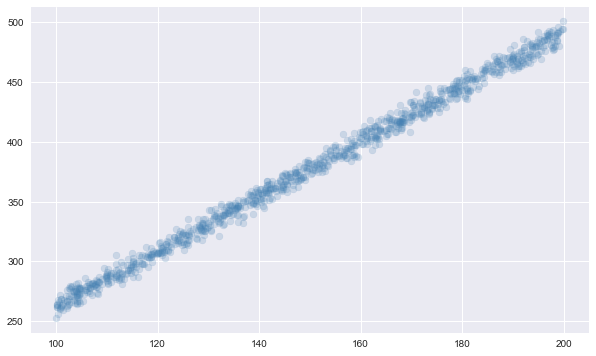

In [6]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

xs = data['x1']
ys = data['y']
axes.scatter(xs, ys, color='steelblue', alpha=0.2)

Now I need to split the data into 10 partitions and perform the cross-validation on each one of them. A helper function is needed.

In [7]:
def ten_cross_validate_mse(formula, data):
    training_mses = []
    test_mses = []
    
    n = data.shape[0]
    #test_n = int( np.round( test_size * n, 0))

    indices = deepcopy(data.index).values
    np.random.shuffle(indices)
    
    for i in range(10):
        lower_bound = int(np.round(i / 10 * n, 0))
        higher_bound = int(np.round((i+1) / 10 * n, 0))
        #print(lower_bound, higher_bound)
        
        test_indices = indices[lower_bound : higher_bound]
        training_indices = list(indices[0:lower_bound]) + list(indices[higher_bound:n])
        #print(test_indices[0], test_indices[-1], len(test_indices))
        #print(training_indices[0], training_indices[-1], len(training_indices))
        
        test_set = data.ix[test_indices]
        training_set = data.ix[training_indices]
        
        y, X = patsy.dmatrices(formula, training_set, return_type="matrix")
        model = linear.LinearRegression(fit_intercept=False).fit(X, y)
        y_hat = model.predict(X)
        training_mse = mse(y - y_hat)
        training_mses.append(training_mse)

        y, X = patsy.dmatrices(formula, test_set, return_type="matrix")
        y_hat = model.predict(X)
        test_mse = mse(y - y_hat)
        test_mses.append(test_mse)

    return training_mses, test_mses

Perform 3 rounds of 10 fold cross-validation on the model, calculating 30 estimates of the MSE.

In [8]:
ten_test_mses = [0] * 30
for i in range(3):
    ten_test_mses[i*10: i*10+10] = ten_cross_validate_mse('y ~ x1', data)[1]
ten_test_mses

[4.9250549359018789,
 4.5365462099643112,
 5.1367075188379214,
 5.2441234481897681,
 4.8899699522155933,
 5.2066934668068736,
 5.428452499979481,
 4.9616734960918274,
 5.3290819467446129,
 5.2989509496672103,
 5.0235083522215938,
 5.0684894460610499,
 4.2547552161244777,
 5.0199686318619152,
 5.0589461024982088,
 5.0432557687146433,
 5.7703032845332896,
 5.4414282739961735,
 5.061294320793527,
 5.167319346925674,
 5.5951351909923206,
 4.6546846248006322,
 4.8333255655274154,
 5.1898355995617145,
 5.316225049317377,
 5.0186824065332605,
 5.199880553028537,
 4.7411650065520794,
 5.4244794216368168,
 4.9999407224039008]

Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Take 10 out of the 30 every time.

In [9]:
def bootstrap_sample(data, f, n=10):
    result = []
    m = len(data)
    for _ in range(n):
        sample = np.random.choice(data, len(data), replace=True)
        r = f(sample)
        result.append(r)
    return np.array(result)

In [10]:
posterior = bootstrap_sample(ten_test_mses, np.mean, 100)

In [11]:
stats.mstats.mquantiles(posterior, [0.05, 0.95])

array([ 5.00984309,  5.1818767 ])

There is a 90% probability that the test MSE is between 5.01 and 5.18 based on the data.

 Calculate the MSE for the true model. How well did you do?

Run the regression. Print true MSE.

In [12]:
result = lm('y ~ x1', data)
print(mse(result['residuals']))

5.09336941437


The true MSE of the model is 5.09, which is exactly at the middle of the 90% confidence interval! This means the cross validation coupled with bootstrap is powerful.

**2\. Pick a Logistic Regression model from the Module 8 Lab that you thought was particularly good at *prediction*.** Although there are different metrics you can use for classification, because this data was made up, let's concentrate on error rate. Perform 3 rounds of 10 fold cross-validation on the model, calculating--in total--30 estimates of the error rate.  Calculate the 90% Credible Intervale from the Non-Parametric Bayesian Boostrap estimate of the posterior distribution. Calculate the MSE for the true model. How well did you do?

**I will use the following relation to generate 1000 samples and do further analysis.**

$X_1$ is normally distributed with $\mu=0.0$ and $\sigma=1.0$ (standard normal).

$X_2$ is standard normally distributed.

$z = 1.0 + 2.0 X_1 + 3 X_2$

$p = \frac{1}{1+e^{-z}}$

use p to generate ys as a bernoulli trial.

In [13]:
np.random.seed([0])

In [14]:
x1 = np.random.normal(0, 1., 1000)
x2 = np.random.normal(0, 1., 1000)
z = 1 + 2 * x1 + 3 * x2
pr = 1 / (1.0 + np.exp(-z))
y = np.array([1 if np.random.random() < pr[i] else 0 for i in range(1000)])
y.mean()

0.56899999999999995

In [15]:
data = pd.DataFrame.from_dict({'y': y, 'x1': x1, 'x2': x2})
data.describe()

,x1,x2,y
count,1000.000000,1000.000000,1000.000000
mean,0.025730,-0.039345,0.569000
std,0.995009,1.052205,0.495464
min,-3.538717,-3.068034,0.000000
25%,-0.625211,-0.754875,0.000000
50%,0.005559,0.019879,1.000000
75%,0.702007,0.700762,1.000000
max,2.821672,3.213794,1.000000


In [16]:
def ten_cross_validate_error_rate(formula, data):
    training_error_rates = []
    test_error_rates = []
    
    n = data.shape[0]
    indices = deepcopy(data.index).values
    np.random.shuffle(indices)
    
    for i in range(10):
        lower_bound = int(np.round(i / 10 * n, 0))
        higher_bound = int(np.round((i+1) / 10 * n, 0))
        
        test_indices = indices[lower_bound : higher_bound]
        training_indices = list(indices[0:lower_bound]) + list(indices[higher_bound:n])
        
        test_set = data.ix[test_indices]
        training_set = data.ix[training_indices]
        
        y, X = patsy.dmatrices(formula, training_set, return_type="matrix")
        y = np.ravel(y)
        model = linear.LogisticRegression(fit_intercept=False).fit(X, y)
        y_hat = model.predict(X)
        #print(y_hat)

        tp = len([1 if item == (1, 1) else None for item in zip(y, y_hat)])
        fn = len([1 if item == (1, 0) else None for item in zip(y, y_hat)])
        training_error_rate = (tp + fn) / (len(y))
        training_error_rates.append(training_error_rate)
        #print(list(zip(y, y_hat))[:100])
        #print(tp)
        #print(fn)

        y, X = patsy.dmatrices(formula, test_set, return_type="matrix")
        y = np.ravel(y)
        y_hat = model.predict(X)
        tp = len([1 if item == (1, 1) else None for item in zip(y, y_hat)])
        fn = len([1 if item == (1, 0) else None for item in zip(y, y_hat)])
        test_error_rate = (tp + fn) / (len(y))
        test_error_rates.append(test_error_rate)

    return training_error_rates, test_error_rates

Note that
**error rate** = $\frac{FP + FN}{N}$

In [17]:
ten_cross_validate_error_rate('y ~ x1 + x2', data)

([2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0],
 [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0])

<font color=blue>
Obviously something is wrong. Guess it lies in the error rate calculation but I am not able to solve it...
</font>

Run the regression.

In [18]:
result = logm('y ~ x1', data)

In [19]:
y, X = patsy.dmatrices('y ~ x1', data, return_type="matrix")
y = np.ravel(y)
model = linear.LogisticRegression(fit_intercept=False).fit(X, y)
y_hat = model.predict(X)
#print(y_hat)

tp = len([1 if item == (1, 1) else None for item in zip(y, y_hat)])
fn = len([1 if item == (1, 0) else None for item in zip(y, y_hat)])
training_error_rate = (tp + fn) / (len(y))
print(training_error_rate)

2.0


<font color=blue>
Obviously something is wrong. Guess it lies in the error rate calculation but I am not able to solve it...
</font>

## Model Improvement

As was discussed in the Lecture, our main method of evaluating whether a model can be improved is through the bias/variance tradeoff. This tradeoff can be evaluated in one of two ways: Learning Curves and Validation Curves.

*Learning Curves* concentrate on the perennial question: will getting more data improve this model?

*Validation Curves* concentrate on a related question: can more variables, regularization, and or transformations improve this model?

Note that these questions are always asked in a predictive sense, looking at the performance metric and its generalization to unseen data (test set). So, if we're to be good practitioners when working with real data, we want to *see* these things happen in controlled circumstances.

### Learning Curves

**1\. Basic Learning Curve.**

Create data for a Linear Regression model as we've done in previous Modules. You should have 3 to 5 variables but it doesn't have to be fancy or tricky. Generate 1000 observations. Plot Learning Curves for the Linear Regression using averaging over 10 fold cross validation. Make a special note of the $\epsilon$ you pick.

Do the Learning Curves indicate that getting more data would improve the model's predictive accuracy? If they do not, generate more data until they indicate you have enough data. How much did you need?

**I will use this model to generate 1000 observations and run the analysis:**

$Y = 32.5 + 2.3 X_1 + 0.8 X_1^2 - 0.05 X_2 + \epsilon$

where $X_1$ is *uniformly* randomly distributed from (10, 25), $X_2$ is *uniformly* randomly distributed from (50, 120) and $\epsilon=N(0, 5.0)$.

In [20]:
np.random.seed([0])

In [21]:
x1 = np.random.uniform(10, 25, 1000)
x2 = np.random.uniform(50, 120, 1000)
e = np.random.normal(0, 5.0, 1000)

y = 32.5 + 2.3 * x1 + 0.8 * x1**2 - 0.05 * x2 + e
data = pd.DataFrame.from_dict({'y': y, 'x1': x1, 'x1_sqr': x1**2, 'x2': x2})

Text(0.5,0,'x2')

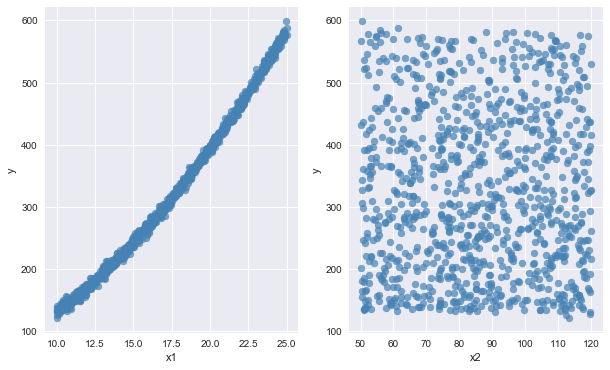

In [22]:
figure = plt.figure(figsize=(10, 6))

axes = figure.add_subplot(121)
axes.scatter(data["x1"], data["y"], marker="o", color="steelblue", alpha=0.7)
axes.set_ylabel("y")
axes.set_xlabel("x1")

axes = figure.add_subplot(122)
axes.scatter(data["x2"], data["y"], marker="o", color="steelblue", alpha=0.7)
axes.set_ylabel("y")
axes.set_xlabel("x2")

To plot Learning Curves for the Linear Regression using averaging over 10 fold cross validation, I need a few helper functions.

In [23]:
def learning_curve( formula, data, increment=0.05, iterations=5, test_size=0.20):
    increments = int( 1.0/increment)
    chunks = [ int(x) for x in np.linspace( 0, data.shape[ 0], increments)][ 1:]
    train = []
    test = []
    for chunk in chunks:
        train_chunk = []
        test_chunk = []
        for i in range( iterations):
            indices = list(range( data.shape[ 0]))
            np.random.shuffle( indices)
            chunk_indices = indices[0:chunk]
            data_chunk = data.ix[ chunk_indices]
            train_mse, test_mse = ten_cross_validate_mse( formula, data_chunk)
            train_chunk.append( train_mse)
            test_chunk.append( test_mse)
        train.append( np.mean( train_chunk))
        test.append( np.mean( test_chunk))
    return chunks, train, test

Text(0.5,1,'Learning Curves for y ~ x1, n = 1000')

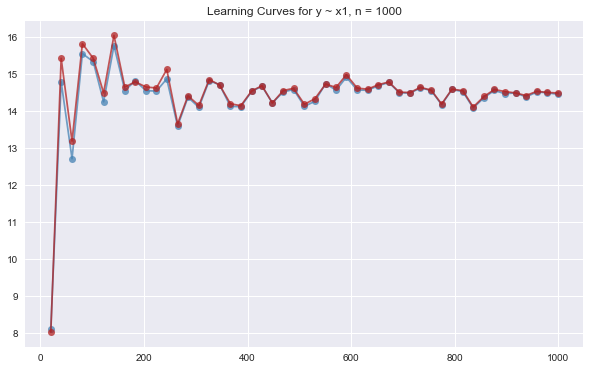

In [24]:
chunks, train, test = learning_curve( "y ~ x1", data, iterations=1, increment=0.02)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")

It looks like getting more data would not help since the model is doing pretty well or is in the high bias zone.

**2\. Increase your $\epsilon$, regenerate the data and re-plot the Learning Curves. Do this several times. Does increasing $\epsilon$ change the convergence of the Learning Curves or the absolute error at convergence?**

Increase $\epsilon=N(0, 50)$.

In [25]:
np.random.seed([0])

In [26]:
x1 = np.random.uniform(10, 25, 1000)
x2 = np.random.uniform(50, 120, 1000)
e = np.random.normal(0, 50., 1000)

y = 32.5 + 2.3 * x1 + 0.8 * x1**2 - 0.05 * x2 + e
data = pd.DataFrame.from_dict({'y': y, 'x1': x1, 'x1_sqr': x1**2, 'x2': x2})

Text(0.5,1,'Learning Curves for y ~ x1, n = 1000')

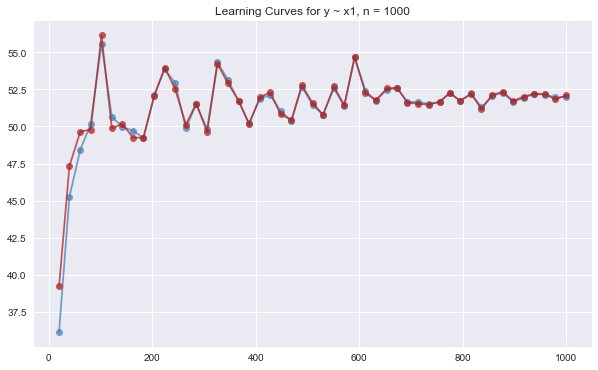

In [27]:
chunks, train, test = learning_curve( "y ~ x1", data, iterations=1, increment=0.02)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")

Increase $\epsilon=N(0, 500)$.

In [28]:
np.random.seed([0])

In [29]:
x1 = np.random.uniform(10, 25, 1000)
x2 = np.random.uniform(50, 120, 1000)
e = np.random.normal(0, 500., 1000)

y = 32.5 + 2.3 * x1 + 0.8 * x1**2 - 0.05 * x2 + e
data = pd.DataFrame.from_dict({'y': y, 'x1': x1, 'x1_sqr': x1**2, 'x2': x2})

Text(0.5,1,'Learning Curves for y ~ x1, n = 1000')

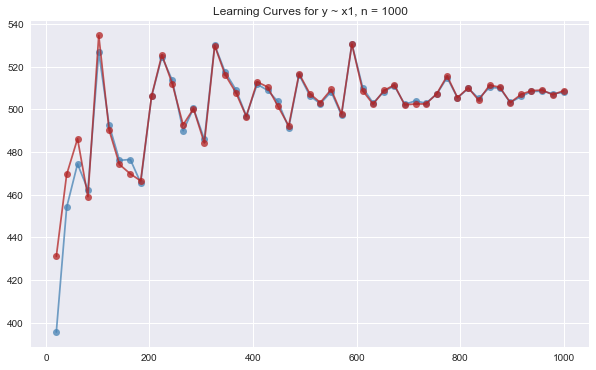

In [30]:
chunks, train, test = learning_curve( "y ~ x1", data, iterations=1, increment=0.02)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")

It looks like increasing $\epsilon$ changed the convergence rate a little bit. More significantly, it changed the absolute error at convergence from 14.5 to 52 to 510!

**3\. Go back to your original $\epsilon$ and instead remove all your variables but one ($X_1$, for example). Now what happens to your Learning Curves? Do they still converge at a higher error rate or do they no longer converge?**

**I will remove X_2 and keep X_1:**

$Y = 32.5 + 2.3 X_1 + 0.8 X_1^2 + \epsilon$

where $X_1$ is *uniformly* randomly distributed from (10, 25) and $\epsilon=N(0, 5.0)$.

In [31]:
np.random.seed([0])

In [32]:
x1 = np.random.uniform(10, 25, 1000)
e = np.random.normal(0, 5., 1000)

y = 32.5 + 2.3 * x1 + 0.8 * x1**2 + e
data = pd.DataFrame.from_dict({'y': y, 'x1': x1, 'x1_sqr': x1**2})

Text(0.5,1,'Learning Curves for y ~ x1, n = 1000')

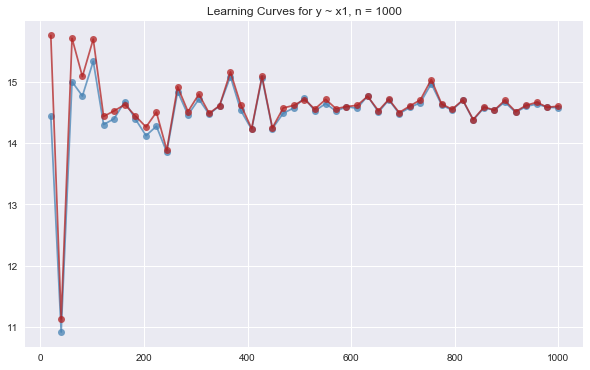

In [33]:
chunks, train, test = learning_curve( "y ~ x1", data, iterations=1, increment=0.02)
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( chunks, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( chunks, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Learning Curves for y ~ x1, n = 1000")

Now the learning curve converges back at the lower error rate, which makes sense.

## Validation Curves

**1\. Basic Validation Curve.**

This one should be pretty straight forward because we've been working with the canonical example. For these experiments, especially, it is probably best to be working with mean centered data. You can simply generate it that way. This will allow you to interpret the $beta$s more as weights/contributions than just scaling factors.

Create data for a Linear Regression model as we've done in previous Modules.  You should have 5 variables (inputs) but only 3 actual $X_i$. Using $D_i$ to indicate actual data, then $X_1 = D_1^1$, $X_2=D_1^n$, $X_3=D_1^{m}$ and $X_4=D_2$ and $X_5=D_3$.

$n$ and $m$ are to control different degrees of the polynomial and $m>n$. Really, you just want something like $D_1^1$, $D_1^2$, $D_1^5$, $D_2$, $D_3$ as your $X_1$, $X_2$, $X_3$, $X_4$, $X_5$.

Basically, you want to do validation curves for all your inputs starting with $X_1$, $X_4$, $X_5$ and then see if they indicate if $X_2$ and or $X_3$ are missing. What happens when the $beta$ is bigger on $X_1$ or the $beta$ is bigger on $X_4$? Does that make a difference? You should experiment with many variations.

**I will use this model to generate 1000 observations and run the analysis:**

$Y = D_1 + 0.8 D_1^2 - 10 D_1^5 + 1.5 D_2 - 0.75 D_3$

where $D_1$ is *uniformly* randomly distributed from (-1, 1), $D_2$ is *uniformly* randomly distributed from (-2, 2) and $D_3$ is standard normally distributed.

In [34]:
np.random.seed([0])

In [35]:
d1 = np.random.uniform(-1., 1., 1000)
d2 = np.random.uniform(-2., 2., 1000)
d3 = np.random.standard_normal(1000)

data = pd.DataFrame.from_dict({'x1': d1, 'x2': d1**2, 'x3': d1**5, 'x4': d2, 'x5': d3})
data['y'] = data['x1'] + 0.8*data['x2'] - 10*data['x3'] + 1.5*data['x4'] -0.75*data['x5']
data.describe()

,x1,x2,x3,x4,x5,y
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,-0.007258,0.336600,-1.188966e-02,0.038044,0.011743,0.429178
std,0.580417,0.305649,3.129087e-01,1.161372,1.017580,3.296011
min,-0.999519,0.000007,-9.975954e-01,-1.995802,-3.029044,-12.796635
25%,-0.495824,0.062894,-2.996890e-02,-0.957861,-0.678956,-1.595438
50%,-0.015856,0.238766,-1.011469e-09,0.026222,0.049030,0.314148
75%,0.480377,0.581853,2.558137e-02,1.064690,0.716916,2.166696
max,0.999370,0.999037,9.968552e-01,1.999611,3.126983,13.430299


First do validation curves for $X_1$.

In [36]:
data[ "x1_1"] = data[ "x1"]**1
data[ "x1_2"] = data[ "x1"]**2
data[ "x1_3"] = data[ "x1"]**3
data[ "x1_4"] = data[ "x1"]**4
data[ "x1_5"] = data[ "x1"]**5

In [37]:
xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x1_1", 
                                 "y ~ x1_2", 
                                 "y ~ x1_3", 
                                 "y ~ x1_4", 
                                 "y ~ x1_5"], data)

[2.6027086786008033, 3.260114184697771, 2.1187899842088789, 3.259436642588605, 1.9562271928970949]
[2.6173468059982694, 3.26999214161442, 2.1232797603770703, 3.2594819633182031, 1.9663553557917024]


Text(0.5,1,'Validation Curves for $x_1^1$ - $x_1^5$')

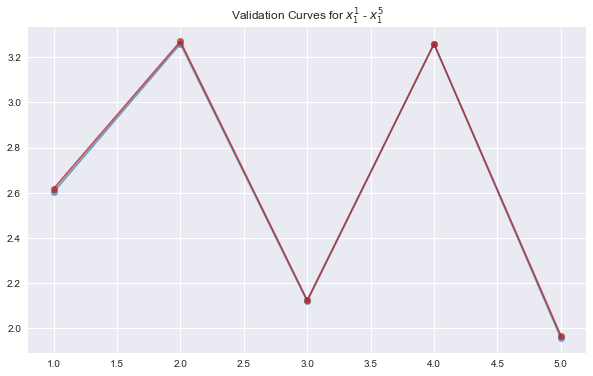

In [38]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x_1^1$ - $x_1^5$")

It shows the a jump with raising $X_1's$ term to 2/4 and a decline to 3/5. It is indicative that $X_1^3$ or $X_1^5$ is missing. The lowest error is at $X_1^5$.

Do validation curves for $X_4$.

[2.8109486246301021, 3.2931388757296025, 2.8626194307469444, 3.29468838416099, 2.9463133081261685]
[2.8058926427521516, 3.2906893712227996, 2.8811122232853963, 3.2790319329922681, 2.9520700759966765]


Text(0.5,1,'Validation Curves for $x_4^1$ - $x_4^5$')

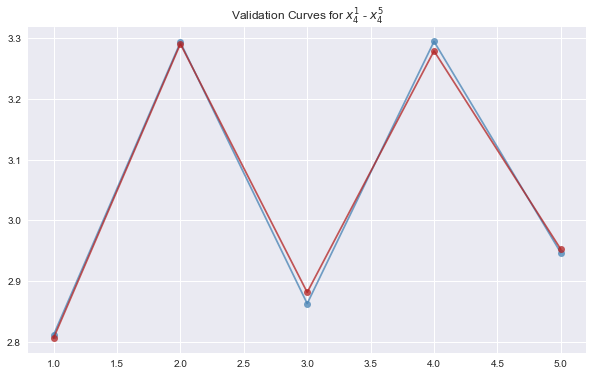

In [39]:
data[ "x4_1"] = data[ "x4"]**1
data[ "x4_2"] = data[ "x4"]**2
data[ "x4_3"] = data[ "x4"]**3
data[ "x4_4"] = data[ "x4"]**4
data[ "x4_5"] = data[ "x4"]**5

xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x4_1", 
                                 "y ~ x4_2", 
                                 "y ~ x4_3", 
                                 "y ~ x4_4", 
                                 "y ~ x4_5"], data)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Validation Curves for $x_4^1$ - $x_4^5$")

Interestingly enough, this is showing a similar trend as that for $X_1$. Probably thanks to the similar distribution between $X_1$ and $X_4$ (both uniform distribution with mean = 0). But since the lowest error is at $X_4^1$, it is OK. 

Do validation curves for $X_5$.

[3.1946129052681367, 3.2870252765954531, 3.2153345326010885, 3.3010910807623515, 3.249684501038844]
[3.1639237662458375, 3.3116140205692464, 3.2280047570919725, 3.2527829358364637, 3.1990433619466789]


Text(0.5,1,'Validation Curves for $x_5^1$ - $x_5^5$')

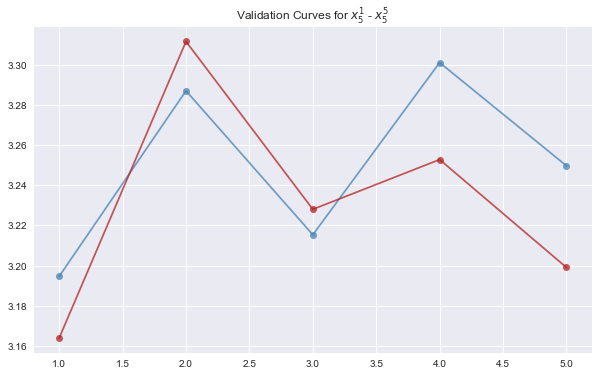

In [40]:
data[ "x5_1"] = data[ "x5"]**1
data[ "x5_2"] = data[ "x5"]**2
data[ "x5_3"] = data[ "x5"]**3
data[ "x5_4"] = data[ "x5"]**4
data[ "x5_5"] = data[ "x5"]**5

xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x5_1", 
                                 "y ~ x5_2", 
                                 "y ~ x5_3", 
                                 "y ~ x5_4", 
                                 "y ~ x5_5"], data)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Validation Curves for $x_5^1$ - $x_5^5$")

This again reflects a minumum error at $X_5^1$, suggesting no missing higher order terms.

I can explore when the $beta$ is smaller on $X_4$ than on $X_1$. Keep everything else the same except the $beta$ for $X_4$.

$Y = D_1 + 0.8 D_1^2 - 10 D_1^5 + 0.15 D_2 - 0.75 D_3$

In [41]:
np.random.seed([0])

In [42]:
d1 = np.random.uniform(-1., 1., 1000)
d2 = np.random.uniform(-2., 2., 1000)
d3 = np.random.standard_normal(1000)

data = pd.DataFrame.from_dict({'x1': d1, 'x2': d1**2, 'x3': d1**5, 'x4': d2, 'x5': d3})
data['y'] = data['x1'] + 0.8*data['x2'] - 10*data['x3'] + 0.15*data['x4'] -0.75*data['x5']
data.describe()

,x1,x2,x3,x4,x5,y
count,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000
mean,-0.007258,0.336600,-1.188966e-02,0.038044,0.011743,0.377818
std,0.580417,0.305649,3.129087e-01,1.161372,1.017580,2.815899
min,-0.999519,0.000007,-9.975954e-01,-1.995802,-3.029044,-10.120898
25%,-0.495824,0.062894,-2.996890e-02,-0.957861,-0.678956,-0.704619
50%,-0.015856,0.238766,-1.011469e-09,0.026222,0.049030,0.149814
75%,0.480377,0.581853,2.558137e-02,1.064690,0.716916,1.009478
max,0.999370,0.999037,9.968552e-01,1.999611,3.126983,11.260355


First do validation curves for $X_1$.

[1.9443871126875181, 2.7698304631364952, 1.1970089415392315, 2.7675500443375798, 0.8935206550280248]
[1.9511522980519309, 2.7712866872169344, 1.2041274329655258, 2.7528099486785904, 0.89375480546054109]


Text(0.5,1,'Validation Curves for $x_1^1$ - $x_1^5$')

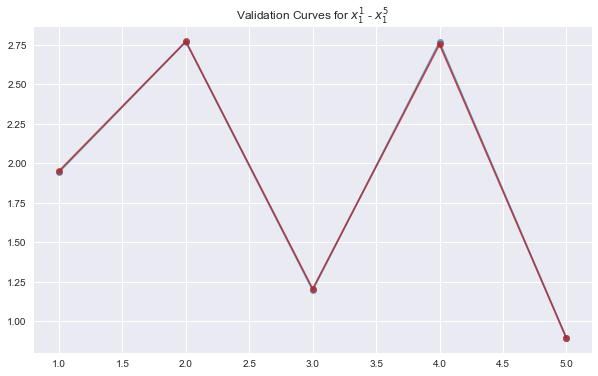

In [43]:
data[ "x1_1"] = data[ "x1"]**1
data[ "x1_2"] = data[ "x1"]**2
data[ "x1_3"] = data[ "x1"]**3
data[ "x1_4"] = data[ "x1"]**4
data[ "x1_5"] = data[ "x1"]**5

xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x1_1", 
                                 "y ~ x1_2", 
                                 "y ~ x1_3", 
                                 "y ~ x1_4", 
                                 "y ~ x1_5"], data)

figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)

axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)

axes.set_title( "Validation Curves for $x_1^1$ - $x_1^5$")

The shape did not change. It shows the a jump with raising $X_1's$ term to 2/4 and a decline to 3/5. It is indicative that $X_1^3$ or $X_1^5$ is missing.

Do validation curves for $X_4$.

[2.8109486246301021, 2.8118983605188586, 2.8045161995647319, 2.8152773005277321, 2.8070826040497172]
[2.805892642752152, 2.8198403637400533, 2.8216796598005676, 2.7994342098361629, 2.8116904173516968]


Text(0.5,1,'Validation Curves for $x_4^1$ - $x_4^5$')

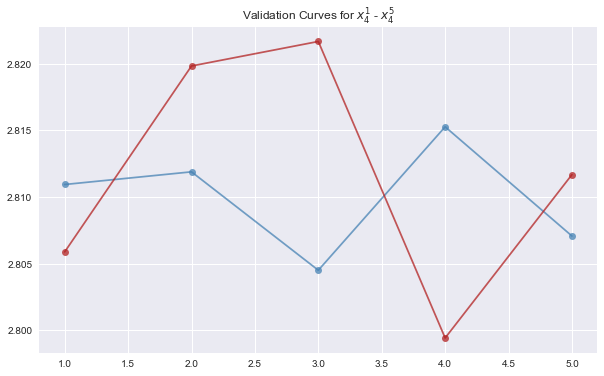

In [44]:
data[ "x4_1"] = data[ "x4"]**1
data[ "x4_2"] = data[ "x4"]**2
data[ "x4_3"] = data[ "x4"]**3
data[ "x4_4"] = data[ "x4"]**4
data[ "x4_5"] = data[ "x4"]**5

xs = [1, 2, 3, 4, 5]
train, test = validation_curves(["y ~ x4_1", 
                                 "y ~ x4_2", 
                                 "y ~ x4_3", 
                                 "y ~ x4_4", 
                                 "y ~ x4_5"], data)

figure = plt.figure(figsize=(10,6))
axes = figure.add_subplot(1, 1, 1)
axes.plot( xs, train, 'o-', color="steelblue", alpha=0.75)
axes.plot( xs, test, "o-", color="firebrick", alpha=0.75)
axes.set_title( "Validation Curves for $x_4^1$ - $x_4^5$")

This time it has changed a lot. The training is low at 3 and the test curve suggests 4. Both are low at 5. The two curves do not match. It is mostly likely coming from the influence of higher orders of $X_1$.